In [4]:
# import the necessary modules
import csv
import pandas as pd
import numpy as np
import tabulate
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

In [5]:
basket_items = pd.read_csv("groceries_basket.csv")
basket_items.head()

,order_id,product_id,product_name,category,add_to_cart_sequence_index
0,1,49302,Bulgarian Yogurt,dairy eggs,1
1,1,10246,Organic Celery Hearts,produce,2
2,1,43633,Lightly Smoked Sardines in Olive Oil,canned goods,3
3,1,13176,Bag of Organic Bananas,produce,4
4,1,47209,Organic Hass Avocado,produce,5


In [6]:
# items
n_items = basket_items['product_id'].nunique()
print(f'Number of unique items: {n_items}')
# orders
n_orders = basket_items['order_id'].nunique()
print(f'Number of unique orders: {n_orders}')
# basket_items
n_basket_items = len(basket_items)
print(f'Number of basket items: {n_basket_items}')

Number of unique items: 26548
Number of unique orders: 64864
Number of basket items: 573124


# a) Product Frequencies

In [7]:
# 每个商品的 support count：出现在多少个不同订单里
support_count = basket_items.groupby("product_id")["order_id"].nunique()


n_orders = basket_items["order_id"].nunique()
min_count_for_1pct = int(np.ceil(0.01 * n_orders))

mean_sc = support_count.mean()
median_sc = support_count.median()

print("n_orders =", n_orders)
print("min_count_for_1% =", min_count_for_1pct)
print("mean_support_count =", mean_sc)
print("median_support_count =", median_sc)

n_orders = 64864
min_count_for_1% = 649
mean_support_count = 21.588217568178393
median_support_count = 4.0


# b) + c) Most frequent Products

You can separate these if you want, but it makes sense to do them together.

In [8]:
# ===== (b) Top-10 products (abs + rel frequency) =====
n_orders = basket_items["order_id"].nunique()

item_support_count = basket_items.groupby("product_id")["order_id"].nunique()
item_support = item_support_count / n_orders

top10 = (pd.DataFrame({
    "product_id": item_support_count.index,
    "abs_freq": item_support_count.values,   # support_count
    "rel_freq": item_support.values          # support
})
         .sort_values(["abs_freq", "product_id"], ascending=[False, True])
         .head(10)
         .reset_index(drop=True))

# (b) theoretical maximum support for size=3 itemset (upper bound) + which ids
top3_ids = top10.loc[:2, "product_id"].tolist()
max_support_size3_upper = top10.loc[2, "rel_freq"]

b_summary = pd.DataFrame({
    "max_support_size3_upper": [max_support_size3_upper],
    "itemset_product_ids": [top3_ids]
})

# ===== (c) How many orders contain all three items? + names for explanation =====
tmp = basket_items[basket_items["product_id"].isin(top3_ids)][["order_id", "product_id"]]
orders_with_all_3 = (tmp.groupby("order_id")["product_id"].nunique() == 3).sum()

id2name = (basket_items[["product_id", "product_name"]]
.drop_duplicates("product_id")
.set_index("product_id")["product_name"])

c_summary = pd.DataFrame({
    "orders_containing_all_three": [int(orders_with_all_3)],
    "product_id_1": [top3_ids[0]],
    "product_name_1": [id2name.get(top3_ids[0], "")],
    "product_id_2": [top3_ids[1]],
    "product_name_2": [id2name.get(top3_ids[1], "")],
    "product_id_3": [top3_ids[2]],
    "product_name_3": [id2name.get(top3_ids[2], "")]
})

# OUTPUT
print("===== (b) Top-10 products (abs_freq + rel_freq) =====")
display(top10)

print("===== (b) Size=3 itemset: maximum support (upper bound) + product_ids =====")
display(b_summary)

print("===== (c) Orders containing all 3 items + their names =====")
display(c_summary)



===== (b) Top-10 products (abs_freq + rel_freq) =====


,product_id,abs_freq,rel_freq
0,24852,9376,0.144549
1,13176,7701,0.118725
2,21137,5480,0.084484
3,21903,4818,0.074278
4,47626,4096,0.063148
5,47766,3670,0.056580
6,47209,3605,0.055578
7,16797,3199,0.049319
8,26209,3017,0.046513
9,27966,2728,0.042057


===== (b) Size=3 itemset: maximum support (upper bound) + product_ids =====


,max_support_size3_upper,itemset_product_ids
0,0.084484,"[24852, 13176, 21137]"


===== (c) Orders containing all 3 items + their names =====


,orders_containing_all_three,product_id_1,product_name_1,product_id_2,product_name_2,product_id_3,product_name_3
0,3,24852,Banana,13176,Bag of Organic Bananas,21137,Organic Strawberries


# d) + e) Product Categories

You don't really need the notebook for e)

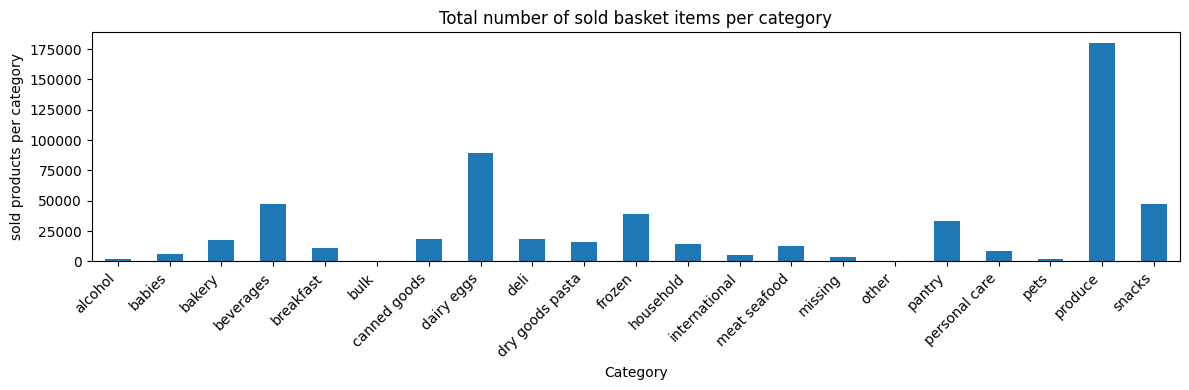

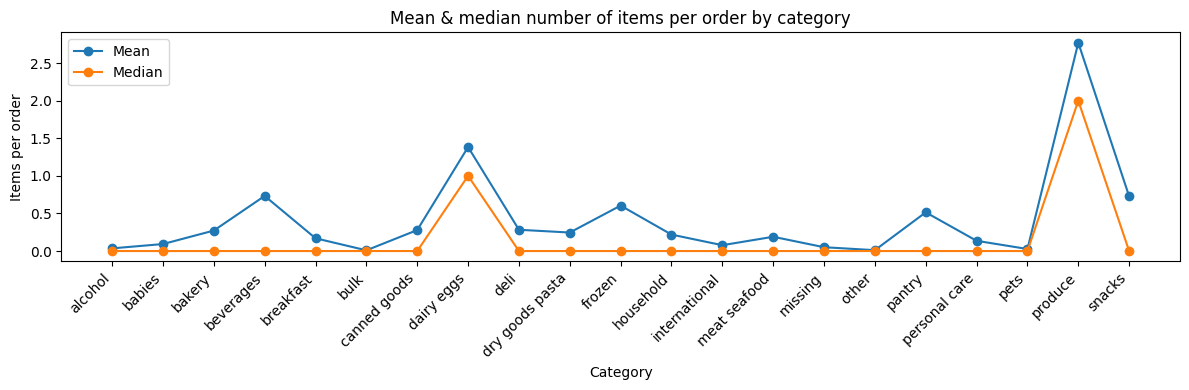

,mean_items_per_order,median_items_per_order
category,,
beverages,0.73,0.0


In [9]:
# ========== (d1) total number of sold products per category ==========
cat_total = basket_items.groupby("category").size().sort_index()  # sort_index => 类别按字母序

plt.figure(figsize=(12, 4))
cat_total.plot(kind="bar")
plt.title("Total number of sold basket items per category")
plt.xlabel("Category")
plt.ylabel("sold products per category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ========== (d2) mean & median #items per order for each category ==========
# 先算：每个订单、每个类别出现了多少行（即该订单买了该类别多少个 item）
order_cat_counts = (
    basket_items
    .groupby(["order_id", "category"])
    .size()
    .unstack(fill_value=0)  # 没买该类的订单记为 0（这样 mean/median 才是“per order”意义上的）
)

# category 按字母序
order_cat_counts = order_cat_counts.reindex(sorted(order_cat_counts.columns), axis=1)

cat_mean = order_cat_counts.mean(axis=0)
cat_median = order_cat_counts.median(axis=0)

cat_stats = pd.DataFrame({
    "mean_items_per_order": cat_mean,
    "median_items_per_order": cat_median
}).sort_index()

plt.figure(figsize=(12, 4))
plt.plot(cat_stats.index, cat_stats["mean_items_per_order"], marker="o", label="Mean")
plt.plot(cat_stats.index, cat_stats["median_items_per_order"], marker="o", label="Median")
plt.title("Mean & median number of items per order by category")
plt.xlabel("Category")
plt.ylabel("Items per order")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# （给(e)用）单独把 beverages 的 mean/median 打出来
display(cat_stats.loc[["beverages"]].round(2))


# f) Frequent Itemsets

In [24]:
# use the provided frequent itemsets.
frequent_itemsets = pd.read_csv('frequent_itemsets.csv')
# format frozensets
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda x: frozenset(eval(x)))
frequent_itemsets.head()



def itemset_to_names(s):
    return [id2name.get(pid, str(pid)) for pid in sorted(s)]

# 1) size
fi = frequent_itemsets.copy()
fi["size"] = fi["itemsets"].apply(len)

# (f1) 最大频繁项集（size 最大）及其商品名称
max_size = fi["size"].max()
f1 = fi.loc[fi["size"] == max_size, ["support", "itemsets", "size"]].copy()
f1["product_names"] = f1["itemsets"].apply(lambda s: ", ".join(itemset_to_names(s)))
f1 = f1.reset_index(drop=True)

# (f2) size >= 2 的频繁项集数量（绝对 + 相对）
n_total = len(fi)
n_ge2 = int((fi["size"] >= 2).sum())
f2 = pd.DataFrame({
    "num_itemsets_size>=2": [n_ge2],
    "num_itemsets_total": [n_total],
    "ratio_size>=2": [n_ge2 / n_total]
})

# (f3) 出现在最多频繁项集中的商品（出现于多少个 itemsets）
item_counts = fi["itemsets"].apply(list).explode().value_counts()
top_pid = int(item_counts.index[0])
top_cnt = int(item_counts.iloc[0])
f3 = pd.DataFrame({
    "product_id": [top_pid],
    "product_name": [id2name.get(top_pid, str(top_pid))],
    "num_frequent_itemsets_containing_it": [top_cnt]
})

# (f4) 只出现在一个频繁项集中的商品数量
f4 = pd.DataFrame({
    "num_products_appearing_in_exactly_one_frequent_itemset": [int((item_counts == 1).sum())]
})

#  OUTPUT
pd.set_option("display.max_colwidth", None)
print("f1 Maximum frequent itemset ")
display(f1[["size", "support", "itemsets", "product_names"]])

print("f2 frequent itemsets with size >= 2 ")
display(f2)

print("f3 Product appearing in the most frequent itemsets")
display(f3)

print("f4 products appearing in exactly one frequent itemset ")
display(f4)

f1 Maximum frequent itemset 


,size,support,itemsets,product_names
0,4,0.001881,"(13176, 47209, 21137, 27966)","Bag of Organic Bananas, Organic Strawberries, Organic Raspberries, Organic Hass Avocado"


f2 frequent itemsets with size >= 2 


,num_itemsets_size>=2,num_itemsets_total,ratio_size>=2
0,1017,1976,0.514676


f3 Product appearing in the most frequent itemsets


,product_id,product_name,num_frequent_itemsets_containing_it
0,24852,Banana,168


f4 products appearing in exactly one frequent itemset 


,num_products_appearing_in_exactly_one_frequent_itemset
0,794


# g) + h) Category Sets

You don't really need the notebook for h)

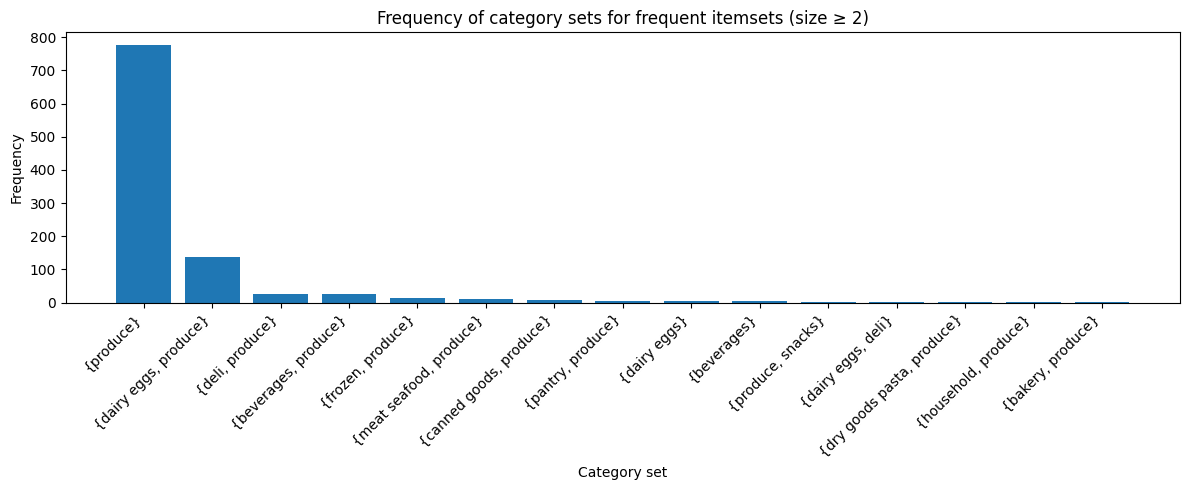

,label,freq
0,{produce},776
1,"{dairy eggs, produce}",137
2,"{deli, produce}",26
3,"{beverages, produce}",25
4,"{frozen, produce}",14
5,"{meat seafood, produce}",11
6,"{canned goods, produce}",7
7,"{pantry, produce}",6
8,{dairy eggs},5
9,{beverages},4


In [16]:
# 1) product_id -> category 映射
pid2cat = (basket_items[["product_id", "category"]]
           .drop_duplicates("product_id")
           .set_index("product_id")["category"]
           .to_dict())

# 2) 只取 size>=2 的 frequent itemsets
fi = frequent_itemsets.copy()
fi["size"] = fi["itemsets"].apply(len)
fi_ge2 = fi[fi["size"] >= 2].copy()

# 3) itemset -> category_set
def itemset_to_category_set(itemset):
    cats = set()
    for pid in itemset:
        cats.add(pid2cat.get(pid, "UNKNOWN"))
    return frozenset(cats)

fi_ge2["category_set"] = fi_ge2["itemsets"].apply(itemset_to_category_set)

# 4) 统计每种 category_set 出现频率
catset_counts = fi_ge2["category_set"].value_counts()

# 5) 让类别集合变成可读标签
def catset_label(catset):
    return "{" + ", ".join(sorted(catset)) + "}"

plot_df = (catset_counts
           .rename_axis("category_set")
           .reset_index(name="freq"))
plot_df["label"] = plot_df["category_set"].apply(catset_label)

# 如果 plot_df 还没按频率降序，确保一下
plot_df = plot_df.sort_values("freq", ascending=False).reset_index(drop=True)

plt.figure(figsize=(max(12, 0.55 * len(plot_df)), 5))
plt.bar(plot_df["label"], plot_df["freq"])
plt.xlabel("Category set")
plt.ylabel("Frequency")
plt.title("Frequency of category sets for frequent itemsets (size ≥ 2)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 统计表
display(plot_df[["label", "freq"]])

# i) Association Rules and Frequent Items

You don't really need the notebook for j)

In [20]:
# determine rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)
rules = rules.drop(columns=["representativity", "leverage", "conviction", "zhangs_metric", "jaccard", "certainty", "kulczynski"])
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,(47209),(13176),0.055578,0.118725,0.018423,0.331484,2.792025
1,(47209),(21137),0.055578,0.084484,0.011486,0.206657,2.446100
2,"(13176, 47209)",(21137),0.018423,0.084484,0.005396,0.292887,3.466756
3,"(13176, 21137)",(47209),0.023942,0.055578,0.005396,0.225370,4.055039
4,"(47209, 21137)",(13176),0.011486,0.118725,0.005396,0.469799,3.957021


In [18]:
# --- 0) top-10 商品集合（优先用你已有的 top10；没有就从 basket_items 现算）---

top10_ids = set(top10["product_id"].tolist())

# --- 1) lift 的均值 & 中位数 ---
lift_mean = rules["lift"].mean()
lift_median = rules["lift"].median()

# --- 2) antecedent / consequent 含 top10 至少一个 ---
has_top10_in_ante = rules["antecedents"].apply(lambda s: len(s & top10_ids) > 0)
has_top10_in_cons = rules["consequents"].apply(lambda s: len(s & top10_ids) > 0)

num_rules = len(rules)
num_ante = int(has_top10_in_ante.sum())
num_cons = int(has_top10_in_cons.sum())

#  输出
i_output1 = pd.DataFrame({
    "lift_mean": [lift_mean],
    "lift_median": [lift_median],
})

i_output2 = pd.DataFrame({
    "num_rules_total": [num_rules],
    "num_rules_antecedent_contains_top10": [num_ante],
    "num_rules_consequent_contains_top10": [num_cons],
})


display(i_output1.round(4))
display(i_output2.round(4))

,lift_mean,lift_median
0,3.9534,2.831


,num_rules_total,num_rules_antecedent_contains_top10,num_rules_consequent_contains_top10
0,453,228,430


# j) Confidence

In [28]:
# 取置信度最高的规则（并列时用 lift、support 打破）
best = (rules.sort_values(["confidence", "lift", "support"], ascending=False)
        .head(1)
        .copy())

def names_from_set(s):
    return [id2name.get(pid, str(pid)) for pid in sorted(list(s))]

best["ante_names"] = best["antecedents"].apply(names_from_set)
best["cons_names"] = best["consequents"].apply(names_from_set)

# consequent 中商品的单品 support（用来解释“为什么后件常是高频商品”）
n_orders = basket_items["order_id"].nunique()
item_support = basket_items.groupby("product_id")["order_id"].nunique() / n_orders

cons_items = list(next(iter(best["consequents"])))
cons_support = pd.DataFrame({
    "product_id": cons_items,
    "product_name": [id2name.get(pid, str(pid)) for pid in cons_items],
    "support": [float(item_support.get(pid, np.nan)) for pid in cons_items]
}).sort_values("support", ascending=False)

# 输出
out_best = best[["antecedents","consequents","support","confidence","lift","ante_names","cons_names"]]
display(out_best)
display(cons_support)




,antecedents,consequents,support,confidence,lift,ante_names,cons_names
42,"(47209, 21137, 27966)",(13176),0.001881,0.622449,5.242765,"[Organic Strawberries, Organic Raspberries, Organic Hass Avocado]",[Bag of Organic Bananas]


,product_id,product_name,support
0,13176,Bag of Organic Bananas,0.118725


# k) No very frequent products, Lift

In [29]:
import pandas as pd
import numpy as np


# --- 1) 过滤：前件和后件都不含 top10 ---
mask_no_top10 = rules["antecedents"].apply(lambda s: len(s & top10_ids) == 0) & \
                rules["consequents"].apply(lambda s: len(s & top10_ids) == 0)

rules_no_top10 = rules[mask_no_top10].copy()

# --- 2) lift 对比统计（你可以按老师习惯用 mean/median，顺便给分位数更直观）---
def lift_stats(x: pd.Series) -> dict:
    return {
        "count": int(x.shape[0]),
        "lift_mean": float(x.mean()),
        "lift_median": float(x.median()),
        "lift_q25": float(x.quantile(0.25)),
        "lift_q75": float(x.quantile(0.75)),
        "lift_min": float(x.min()),
        "lift_max": float(x.max()),
    }

overall = lift_stats(rules["lift"])
subset  = lift_stats(rules_no_top10["lift"])

k_table = pd.DataFrame([overall, subset], index=["All rules", "Rules w/o Top-10 in A and B"])
display(k_table.round(4))




,count,lift_mean,lift_median,lift_q25,lift_q75,lift_min,lift_max
All rules,453,3.9534,2.8310,2.0210,3.8676,1.3985,73.4109
Rules w/o Top-10 in A and B,16,26.9801,10.9025,9.3803,47.4371,5.9839,73.4109


# l) Sub-sequences

In [35]:
# function from the exercise notebook
def contained(is_seq1, is_seq2):
    size1 = len(is_seq1)
    size2 = len(is_seq2)

    if size1 > size2:
        return False

    last_1 = 0
    last_2 = 0

    while last_1 < size1 and last_2 < size2:
        item1 = is_seq1[last_1]
        item2 = is_seq2[last_2]
        if item1 == item2:
            last_1 += 1
        last_2 += 1

    if last_1 == size1:
        return True
    else:
        return False


seq_col = "add_to_cart_sequence_index"

# ===== 1) 只保留 A、B 都是单元素集合的规则 =====
single_rules = rules[
    (rules["antecedents"].apply(len) == 1) &
    (rules["consequents"].apply(len) == 1)
    ].copy()

single_rules["a"] = single_rules["antecedents"].apply(lambda s: next(iter(s)))
single_rules["b"] = single_rules["consequents"].apply(lambda s: next(iter(s)))

pair_set = set(zip(single_rules["a"], single_rules["b"]))

# ===== 2) 找双向对： (a,b) 和 (b,a) 都存在，只保留一次（无序对去重）=====
bidirectional_pairs = []
seen = set()
for a, b in pair_set:
    if (b, a) in pair_set:
        key = (min(a, b), max(a, b))
        if key not in seen:
            seen.add(key)
            bidirectional_pairs.append(key)  # (small, large)


# ===== 3) 为了算序列，先取这些 pair 涉及的所有商品 id =====
items_needed = set([x for p in bidirectional_pairs for x in p])

# ===== 4) 为每个订单构造：只记录这些商品的最早/最晚位置（用于判断 ⟨a,b⟩）=====
# order_pos[order_id] = {pid: (min_pos, max_pos)}
order_pos = {}

# 排序保证序列位置正确（严格来说我们用的是 seq_col 本身）
df_seq = basket_items[["order_id", "product_id", seq_col]].sort_values(["order_id", seq_col])

for oid, grp in df_seq.groupby("order_id", sort=False):
    d_min = {}
    d_max = {}
    # grp 可能很长，但我们只关心 items_needed
    for pid, pos in zip(grp["product_id"].values, grp[seq_col].values):
        if pid in items_needed:
            if pid not in d_min:
                d_min[pid] = pos
                d_max[pid] = pos
            else:
                if pos < d_min[pid]:
                    d_min[pid] = pos
                if pos > d_max[pid]:
                    d_max[pid] = pos
    if d_min:  # 该订单至少包含一个我们关心的商品
        order_pos[oid] = (d_min, d_max)
# ===== 5) product_id -> product_name（输出更好看）=====
id2name = (basket_items[["product_id", "product_name"]]
           .drop_duplicates("product_id")
           .set_index("product_id")["product_name"]
           .to_dict())
# ===== 6) 计算 support_count(⟨a,b⟩) 和 support_count(⟨b,a⟩) =====
results = []
order_values = list(order_pos.values())  # 只存 dict，遍历更快
for a, b in bidirectional_pairs:
    ab = 0
    ba = 0
    for d_min, d_max in order_values:
        # ⟨a,b⟩：存在 a 在前 b 在后 -> min_pos(a) < max_pos(b)
        if (a in d_min) and (b in d_max) and (d_min[a] < d_max[b]):
            ab += 1
        # ⟨b,a⟩：min_pos(b) < max_pos(a)
        if (b in d_min) and (a in d_max) and (d_min[b] < d_max[a]):
            ba += 1
    results.append({
        "a": a,
        "a_name": id2name.get(a, str(a)),
        "b": b,
        "b_name": id2name.get(b, str(b)),
        "support_count_<a,b>": ab,
        "support_count_<b,a>": ba
    })
result_df = pd.DataFrame(results).sort_values(
    ["support_count_<a,b>", "support_count_<b,a>"],
    ascending=False
).reset_index(drop=True)
display(result_df)
print(result_df.to_markdown())

,a,a_name,b,b_name,"support_count_<a,b>","support_count_<b,a>"
0,13176,Bag of Organic Bananas,21137,Organic Strawberries,1149,404
1,33754,Total 2% with Strawberry Lowfat Greek Strained Yogurt,33787,Total 2% Lowfat Greek Strained Yogurt with Peach,69,47
2,28465,Icelandic Style Skyr Blueberry Non-fat Yogurt,36865,Non Fat Raspberry Yogurt,59,61
3,4957,Total 2% Lowfat Greek Strained Yogurt With Blueberry,33754,Total 2% with Strawberry Lowfat Greek Strained Yogurt,53,57


|    |     a | a_name                                                |     b | b_name                                                |   support_count_<a,b> |   support_count_<b,a> |
|---:|------:|:------------------------------------------------------|------:|:------------------------------------------------------|----------------------:|----------------------:|
|  0 | 13176 | Bag of Organic Bananas                                | 21137 | Organic Strawberries                                  |                  1149 |                   404 |
|  1 | 33754 | Total 2% with Strawberry Lowfat Greek Strained Yogurt | 33787 | Total 2% Lowfat Greek Strained Yogurt with Peach      |                    69 |                    47 |
|  2 | 28465 | Icelandic Style Skyr Blueberry Non-fat Yogurt         | 36865 | Non Fat Raspberry Yogurt                              |                    59 |                    61 |
|  3 |  4957 | Total 2% Lowfat Greek Strained Yogurt With Blueberry  | 33754 | Total 

# m) Rules with support count > 99, confidence > 0.2, Lift < 1

You don't need any new calculations for this. Rather consult the lecture slides and your answer for b)